In [1]:
!pip install einops vector-quantize-pytorch

import os
import sys
import math
import json
from tqdm import tqdm
from math import floor, log2
from random import random
from shutil import rmtree
from functools import partial
import multiprocessing
from contextlib import contextmanager, ExitStack
import numpy as np
import torch
from torch import nn, einsum
from torch.utils import data
from torch.optim import Adam
import torch.nn.functional as F
from torch.autograd import grad as torch_grad
from einops import rearrange, repeat
from kornia.filters import filter2D
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
from vector_quantize_pytorch import VectorQuantize
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import gc

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cudnn.benchmark = True

     |████████████████████████████████| 41 kB 164 kB/s eta 0:00:01


## Dataset

In [2]:
image_paths = os.listdir("/kaggle/input/annularlichenp/")
image_paths = [f"/kaggle/input/annularlichenp/{el}" for el in image_paths]

class ImageDataset(Dataset):
    def __init__(self, image_paths):
        super().__init__()
        self.image_paths = image_paths
        self.transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.RandomGrayscale(0.5),
            transforms.RandomHorizontalFlip(0.5), 
            transforms.ToTensor()
        ])
        self.cutout = transforms.Compose([
            transforms.RandomErasing(p=0.66, value=1.0, scale=(0.02, 0.1)),
            transforms.RandomErasing(p=0.66, value=1.0, scale=(0.02, 0.1)),
            transforms.RandomErasing(p=0.66, value=1.0, scale=(0.02, 0.1)),
            transforms.RandomErasing(p=0.66, value=1.0, scale=(0.02, 0.1)),
            transforms.RandomErasing(p=0.66, value=1.0, scale=(0.02, 0.1)),
            transforms.RandomErasing(p=0.66, value=1.0, scale=(0.02, 0.1)),
            transforms.RandomErasing(p=0.66, value=1.0, scale=(0.02, 0.1)),
            transforms.RandomErasing(p=0.66, value=1.0, scale=(0.02, 0.1)),
        ])
        self.normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        image = Image.open(self.image_paths[index])
        image = self.transform(image)
        mask = torch.zeros((3, 128, 128))
        mask = self.cutout(mask)
        image_cutout = torch.where(mask == 1.0, torch.ones_like(image), image)
        return self.normalize(image), self.normalize(image_cutout), self.normalize(mask), mask

## Models

In [6]:
NUM_CORES = multiprocessing.cpu_count()
EXTS = ['jpg', 'jpeg', 'png']

class NanException(Exception):
    pass

class EMA():
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
    def update_average(self, old, new):
        if not exists(old):
            return new
        return old * self.beta + (1 - self.beta) * new

class Flatten(nn.Module):
    def forward(self, x):
        return x.reshape(x.shape[0], -1)


In [7]:
class RandomApply(nn.Module):
    def __init__(self, prob, fn, fn_else = lambda x: x):
        super().__init__()
        self.fn = fn
        self.fn_else = fn_else
        self.prob = prob
    def forward(self, x):
        fn = self.fn if random() < self.prob else self.fn_else
        return fn(x)

In [8]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x):
        return self.fn(x) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = ChanNorm(dim)

    def forward(self, x):
        return self.fn(self.norm(x))

In [9]:
class ChanNorm(nn.Module):
    def __init__(self, dim, eps = 1e-5):
        super().__init__()
        self.eps = eps
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))
        self.b = nn.Parameter(torch.zeros(1, dim, 1, 1))

    def forward(self, x):
        std = torch.var(x, dim = 1, unbiased = False, keepdim = True).sqrt()
        mean = torch.mean(x, dim = 1, keepdim = True)
        return (x - mean) / (std + self.eps) * self.g + self.b

class PermuteToFrom(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn
    def forward(self, x):
        x = x.permute(0, 2, 3, 1)
        out, loss = self.fn(x)
        out = out.permute(0, 3, 1, 2)
        return out, loss


In [10]:
class Blur(nn.Module):
    def __init__(self):
        super().__init__()
        f = torch.Tensor([1, 2, 1])
        self.register_buffer('f', f)
    def forward(self, x):
        f = self.f
        f = f[None, None, :] * f [None, :, None]
        return filter2D(x, f, normalized=True)

# attention

class DepthWiseConv2d(nn.Module):
    def __init__(self, dim_in, dim_out, kernel_size, padding = 0, stride = 1, bias = True):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(dim_in, dim_in, kernel_size = kernel_size, padding = padding, groups = dim_in, stride = stride, bias = bias),
            nn.Conv2d(dim_in, dim_out, kernel_size = 1, bias = bias)
        )
    def forward(self, x):
        return self.net(x)


In [11]:

class LinearAttention(nn.Module):
    def __init__(self, dim, dim_head = 64, heads = 8):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        inner_dim = dim_head * heads

        self.nonlin = nn.GELU()
        self.to_q = nn.Conv2d(dim, inner_dim, 1, bias = False)
        self.to_kv = DepthWiseConv2d(dim, inner_dim * 2, 3, padding = 1, bias = False)
        self.to_out = nn.Conv2d(inner_dim, dim, 1)

    def forward(self, fmap):
        h, x, y = self.heads, *fmap.shape[-2:]
        q, k, v = (self.to_q(fmap), *self.to_kv(fmap).chunk(2, dim = 1))
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> (b h) (x y) c', h = h), (q, k, v))

        q = q.softmax(dim = -1)
        k = k.softmax(dim = -2)

        q = q * self.scale

        context = einsum('b n d, b n e -> b d e', k, v)
        out = einsum('b n d, b d e -> b n e', q, context)
        out = rearrange(out, '(b h) (x y) d -> b (h d) x y', h = h, x = x, y = y)

        out = self.nonlin(out)
        return self.to_out(out)

# one layer of self-attention and feedforward, for images

attn_and_ff = lambda chan: nn.Sequential(*[
    Residual(PreNorm(chan, LinearAttention(chan))),
    Residual(PreNorm(chan, nn.Sequential(nn.Conv2d(chan, chan * 2, 1), leaky_relu(), nn.Conv2d(chan * 2, chan, 1))))
])

# helpers

def exists(val):
    return val is not None

@contextmanager
def null_context():
    yield

def combine_contexts(contexts):
    @contextmanager
    def multi_contexts():
        with ExitStack() as stack:
            yield [stack.enter_context(ctx()) for ctx in contexts]
    return multi_contexts

def default(value, d):
    return value if exists(value) else d

def cycle(iterable):
    while True:
        for i in iterable:
            yield i

def cast_list(el):
    return el if isinstance(el, list) else [el]

def is_empty(t):
    if isinstance(t, torch.Tensor):
        return t.nelement() == 0
    return not exists(t)

def raise_if_nan(t):
    if torch.isnan(t):
        raise NanException

def gradient_penalty(images, output, weight = 10):
    batch_size = images.shape[0]
    gradients = torch_grad(outputs=output, inputs=images,
                           grad_outputs=torch.ones(output.size(), device=images.device),
                           create_graph=True, retain_graph=True, only_inputs=True)[0]

    gradients = gradients.reshape(batch_size, -1)
    return weight * ((gradients.norm(2, dim=1) - 1) ** 2).mean()

def calc_pl_lengths(styles, images):
    device = images.device
    num_pixels = images.shape[2] * images.shape[3]
    pl_noise = torch.randn(images.shape, device=device) / math.sqrt(num_pixels)
    outputs = (images * pl_noise).sum()

    pl_grads = torch_grad(outputs=outputs, inputs=styles,
                          grad_outputs=torch.ones(outputs.shape, device=device),
                          create_graph=True, retain_graph=True, only_inputs=True)[0]

    return (pl_grads ** 2).sum(dim=2).mean(dim=1).sqrt()

def noise(n, latent_dim, device):
    return torch.randn(n, latent_dim).cuda(device)

def noise_list(n, layers, latent_dim, device):
    return [(noise(n, latent_dim, device), layers)]

def mixed_list(n, layers, latent_dim, device):
    tt = int(torch.rand(()).numpy() * layers)
    return noise_list(n, tt, latent_dim, device) + noise_list(n, layers - tt, latent_dim, device)

def latent_to_w(style_vectorizer, latent_descr):
    """print()
    for z, num_layers in latent_descr:
        print(z.shape)
        print(num_layers)
    print()"""
    return [(style_vectorizer(z), num_layers) for z, num_layers in latent_descr]

def image_noise(n, im_size, device):
    return torch.FloatTensor(n, im_size, im_size, 1).uniform_(0., 1.).cuda(device)

def leaky_relu(p=0.2):
    return nn.LeakyReLU(p, inplace=True)

def evaluate_in_chunks(max_batch_size, model, *args):
    split_args = list(zip(*list(map(lambda x: x.split(max_batch_size, dim=0), args))))
    chunked_outputs = [model(*i) for i in split_args]
    if len(chunked_outputs) == 1:
        return chunked_outputs[0]
    return torch.cat(chunked_outputs, dim=0)

def styles_def_to_tensor(styles_def):
    return torch.cat([t[:, None, :].expand(-1, n, -1) for t, n in styles_def], dim=1)

def set_requires_grad(model, bool):
    for p in model.parameters():
        p.requires_grad = bool

def slerp(val, low, high):
    low_norm = low / torch.norm(low, dim=1, keepdim=True)
    high_norm = high / torch.norm(high, dim=1, keepdim=True)
    omega = torch.acos((low_norm * high_norm).sum(1))
    so = torch.sin(omega)
    res = (torch.sin((1.0 - val) * omega) / so).unsqueeze(1) * low + (torch.sin(val * omega) / so).unsqueeze(1) * high
    return res

def d_logistic_loss(fake_pred, real_pred):
    real_loss = F.softplus(-real_pred)
    fake_loss = F.softplus(fake_pred)

    return real_loss.mean() + fake_loss.mean()

def g_nonsaturating_loss(fake_pred):
    loss = F.softplus(-fake_pred).mean()

    return loss

def gen_hinge_loss(fake, real):
    return fake.mean()

def hinge_loss(fake):
    return (F.relu(1 + real) + F.relu(1 - fake)).mean() 

# stylegan2 classes
class EqualLinear(nn.Module):
    def __init__(self, in_dim, out_dim, lr_mul = 1, bias = True):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(out_dim, in_dim))
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_dim))

        self.lr_mul = lr_mul

    def forward(self, input):
        return F.linear(input, self.weight * self.lr_mul, bias=self.bias * self.lr_mul)

class MappingNet(nn.Module):
    def __init__(self, emb, depth, lr_mul = 0.1):
        super().__init__()
        layers = []
        for i in range(depth):
            layers.extend([EqualLinear(emb, emb, lr_mul), leaky_relu()])

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = F.normalize(x, dim=1)
        return self.net(x)

class RGBBlock(nn.Module):
    def __init__(self, latent_dim, input_channel, upsample, rgba = False):
        super().__init__()
        self.input_channel = input_channel
        self.to_style = nn.Linear(latent_dim, input_channel)

        out_filters = 3 if not rgba else 4
        self.conv = Conv2DMod(input_channel, out_filters, 1, demod=False)

        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor = 2, mode='bilinear', align_corners=False),
            Blur()
        ) if upsample else None

    def forward(self, x, prev_rgb, istyle):
        b, c, h, w = x.shape
        style = self.to_style(istyle)
        x = self.conv(x, style)

        if exists(prev_rgb):
            x = x + prev_rgb

        if exists(self.upsample):
            x = self.upsample(x)

        return x

class Conv2DMod(nn.Module):
    def __init__(self, in_chan, out_chan, kernel, demod=True, stride=1, dilation=1, eps = 1e-8, **kwargs):
        super().__init__()
        self.filters = out_chan
        self.demod = demod
        self.kernel = kernel
        self.stride = stride
        self.dilation = dilation
        self.weight = nn.Parameter(torch.randn((out_chan, in_chan, kernel, kernel)))
        self.eps = eps
        nn.init.kaiming_normal_(self.weight, a=0, mode='fan_in', nonlinearity='leaky_relu')

    def _get_same_padding(self, size, kernel, dilation, stride):
        return ((size - 1) * (stride - 1) + dilation * (kernel - 1)) // 2

    def forward(self, x, y):
        b, c, h, w = x.shape

        w1 = y[:, None, :, None, None]
        w2 = self.weight[None, :, :, :, :]
        weights = w2 * (w1 + 1)

        if self.demod:
            d = torch.rsqrt((weights ** 2).sum(dim=(2, 3, 4), keepdim=True) + self.eps)
            weights = weights * d

        x = x.reshape(1, -1, h, w)

        _, _, *ws = weights.shape
        weights = weights.reshape(b * self.filters, *ws)

        padding = self._get_same_padding(h, self.kernel, self.dilation, self.stride)
        x = F.conv2d(x, weights, padding=padding, groups=b)

        x = x.reshape(-1, self.filters, h, w)
        return x

class GeneratorBlock(nn.Module):
    def __init__(self, latent_dim, input_channels, filters, upsample = True, upsample_rgb = True, rgba = False):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False) if upsample else None

        self.to_style1 = nn.Linear(latent_dim, input_channels)
        self.to_noise1 = nn.Linear(1, filters)
        self.conv1 = Conv2DMod(input_channels, filters, 3)
        
        self.to_style2 = nn.Linear(latent_dim, filters)
        self.to_noise2 = nn.Linear(1, filters)
        self.conv2 = Conv2DMod(filters, filters, 3)

        self.activation = leaky_relu()
        self.to_rgb = RGBBlock(latent_dim, filters, upsample_rgb, rgba)

    def forward(self, x, prev_rgb, istyle, inoise):
        if exists(self.upsample):
            x = self.upsample(x)

        inoise = inoise[:, :x.shape[2], :x.shape[3], :]
        noise1 = self.to_noise1(inoise).permute((0, 3, 2, 1))
        noise2 = self.to_noise2(inoise).permute((0, 3, 2, 1))

        style1 = self.to_style1(istyle)
        x = self.conv1(x, style1)
        x = self.activation(x + noise1)

        style2 = self.to_style2(istyle)
        x = self.conv2(x, style2)
        x = self.activation(x + noise2)

        rgb = self.to_rgb(x, prev_rgb, istyle)
        return x, rgb

class DiscriminatorBlock(nn.Module):
    def __init__(self, input_channels, filters, downsample=True):
        super().__init__()
        self.conv_res = nn.Conv2d(input_channels, filters, 1, stride = (2 if downsample else 1))

        self.net = nn.Sequential(
            nn.Conv2d(input_channels, filters, 3, padding=1),
            leaky_relu(),
            nn.Conv2d(filters, filters, 3, padding=1),
            leaky_relu()
        )

        self.downsample = nn.Sequential(
            Blur(),
            nn.Conv2d(filters, filters, 3, padding = 1, stride = 2)
        ) if downsample else None

    def forward(self, x):
        res = self.conv_res(x)
        x = self.net(x)
        if exists(self.downsample):
            x = self.downsample(x)
        x = (x + res) * (1 / math.sqrt(2))
        return x

class Generator(nn.Module):
    def __init__(self, image_size, latent_dim, network_capacity = 16, transparent = False, attn_layers = [], fmap_max = 512):
        super().__init__()
        self.image_size = image_size
        self.latent_dim = latent_dim
        self.num_layers = int(log2(image_size) - 1)

        filters = [network_capacity * (2 ** (i + 1)) for i in range(self.num_layers)][::-1]

        set_fmap_max = partial(min, fmap_max)
        filters = list(map(set_fmap_max, filters))
        init_channels = filters[0]
        filters = [init_channels, *filters]

        in_out_pairs = zip(filters[:-1], filters[1:])

        
        self.initial_block = nn.Parameter(torch.randn((1, init_channels, 4, 4)))

        self.initial_conv = nn.Conv2d(filters[0], filters[0], 3, padding=1)
        self.blocks = nn.ModuleList([])
        self.attns = nn.ModuleList([])

        for ind, (in_chan, out_chan) in enumerate(in_out_pairs):
            not_first = ind != 0
            not_last = ind != (self.num_layers - 1)
            num_layer = self.num_layers - ind

            attn_fn = attn_and_ff(in_chan) if num_layer in attn_layers else None

            self.attns.append(attn_fn)

            block = GeneratorBlock(
                latent_dim * 3,
                in_chan,
                out_chan,
                upsample = not_first,
                upsample_rgb = not_last,
                rgba = transparent
            )
            self.blocks.append(block)

    def forward(self, styles_mapping, styles_encoder, input_noise):
        batch_size = styles_mapping.shape[0]
        image_size = self.image_size
        
        styles_encoder = styles_encoder.unsqueeze(1)
        styles_encoder = styles_encoder.expand(
            styles_encoder.shape[0], 
            styles_mapping.shape[1], 
            styles_encoder.shape[2]
        )
        
        styles = torch.cat([styles_mapping, styles_encoder], dim=2)

        x = self.initial_block.expand(batch_size, -1, -1, -1)

        rgb = None
        styles = styles.transpose(0, 1)
        x = self.initial_conv(x)

        for style, block, attn in zip(styles, self.blocks, self.attns):
            if exists(attn):
                x = attn(x)
            x, rgb = block(x, rgb, style, input_noise)

        return rgb
    
class Encoder(nn.Module):
    def __init__(self, image_size, network_capacity = 32, fq_layers = [], fq_dict_size = 256, attn_layers = [], transparent = False, fmap_max = 512):
        super().__init__()
        num_layers = int(log2(image_size) - 1)
        num_init_filters = 3 if not transparent else 4

        blocks = []
        filters = [num_init_filters + 3] + [(network_capacity * 4) * (2 ** i) for i in range(num_layers + 1)]

        set_fmap_max = partial(min, fmap_max)
        filters = list(map(set_fmap_max, filters))
        chan_in_out = list(zip(filters[:-1], filters[1:]))

        blocks = []
        attn_blocks = []

        for ind, (in_chan, out_chan) in enumerate(chan_in_out):
            num_layer = ind + 1
            is_not_last = ind != (len(chan_in_out) - 1)

            block = DiscriminatorBlock(in_chan, out_chan, downsample = is_not_last)
            blocks.append(block)

            attn_fn = attn_and_ff(out_chan) if num_layer in attn_layers else None

            attn_blocks.append(attn_fn)

        self.blocks = nn.ModuleList(blocks)
        self.attn_blocks = nn.ModuleList(attn_blocks)

        chan_last = filters[-1]
        latent_dim = 2 * 2 * chan_last

        self.final_conv = nn.Conv2d(chan_last, chan_last, 3, padding=1)
        self.flatten = Flatten()
        self.to_latent = nn.Linear(latent_dim, 1024)
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x,  mask_norm_batch):
        b, *_ = x.shape
        
        x = torch.cat([x, mask_norm_batch], dim=1)
        
        for (block, attn_block) in zip(self.blocks, self.attn_blocks):
            x = block(x)

            if exists(attn_block):
                x = attn_block(x)

        x = self.final_conv(x)
        x = self.flatten(x)
        x = self.to_latent(x)
        x = self.dropout(x)
        return x.squeeze()

class Discriminator(nn.Module):
    def __init__(self, image_size, network_capacity = 16, fq_layers = [], fq_dict_size = 256, attn_layers = [], transparent = False, fmap_max = 512):
        super().__init__()
        num_layers = int(log2(image_size) - 1)
        num_init_filters = 6

        blocks = []
        filters = [num_init_filters] + [(network_capacity * 4) * (2 ** i) for i in range(num_layers + 1)]

        set_fmap_max = partial(min, fmap_max)
        filters = list(map(set_fmap_max, filters))
        chan_in_out = list(zip(filters[:-1], filters[1:]))

        blocks = []
        attn_blocks = []
        quantize_blocks = []

        for ind, (in_chan, out_chan) in enumerate(chan_in_out):
            num_layer = ind + 1
            is_not_last = ind != (len(chan_in_out) - 1)

            block = DiscriminatorBlock(in_chan, out_chan, downsample = is_not_last)
            blocks.append(block)

            attn_fn = attn_and_ff(out_chan) if num_layer in attn_layers else None

            attn_blocks.append(attn_fn)

            quantize_fn = PermuteToFrom(VectorQuantize(out_chan, fq_dict_size)) if num_layer in fq_layers else None
            quantize_blocks.append(quantize_fn)

        self.blocks = nn.ModuleList(blocks)
        self.attn_blocks = nn.ModuleList(attn_blocks)
        self.quantize_blocks = nn.ModuleList(quantize_blocks)

        chan_last = filters[-1]
        latent_dim = 2 * 2 * chan_last

        self.final_conv = nn.Conv2d(chan_last, chan_last, 3, padding=1)
        self.flatten = Flatten()
        self.to_logit = nn.Linear(latent_dim, 1)

    def forward(self, x, mask):
        b, *_ = x.shape
        
        x = torch.cat([x, mask], dim=1)
        
        quantize_loss = torch.zeros(1).to(x)

        for (block, attn_block, q_block) in zip(self.blocks, self.attn_blocks, self.quantize_blocks):
            x = block(x)

            if exists(attn_block):
                x = attn_block(x)

            if exists(q_block):
                x, _, loss = q_block(x)
                quantize_loss += loss

        x = self.final_conv(x)
        x = self.flatten(x)
        x = self.to_logit(x)
        return x.squeeze(), quantize_loss

class StyleGAN2(nn.Module):
    def __init__(self, image_size, latent_dim = 512, fmap_max = 512, style_depth = 8, network_capacity = 16, transparent = False, steps = 1, lr = 1e-4, ttur_mult = 2, fq_layers = [], fq_dict_size = 256, attn_layers = [], lr_mlp = 0.1, rank = 0):
        super().__init__()
        self.lr = lr
        self.steps = steps
        self.ema_updater = EMA(0.995)

        self.S = MappingNet(latent_dim, style_depth, lr_mul = lr_mlp)
        self.G = Generator(image_size, latent_dim, network_capacity, transparent = transparent, attn_layers = attn_layers, fmap_max = fmap_max)
        self.D = Discriminator(image_size, network_capacity, fq_layers = fq_layers, fq_dict_size = fq_dict_size, attn_layers = attn_layers, transparent = transparent, fmap_max = fmap_max)
        self.E = Encoder(image_size, network_capacity, fq_layers = fq_layers, fq_dict_size = fq_dict_size, attn_layers = attn_layers, transparent = transparent, fmap_max = fmap_max)
        self.SE = MappingNet(latent_dim, style_depth, lr_mul = lr_mlp)
        self.GE = Generator(image_size, latent_dim, network_capacity, transparent = transparent, attn_layers = attn_layers)
        self.EE = Encoder(image_size, network_capacity, fq_layers = fq_layers, fq_dict_size = fq_dict_size, attn_layers = attn_layers, transparent = transparent, fmap_max = fmap_max)
        
        print(self.S)
        print(self.D)
        print(self.G)
        print(self.E)

        
        self.D_cl = None

        # turn off grad for exponential moving averages
        set_requires_grad(self.SE, False)
        set_requires_grad(self.GE, False)
        set_requires_grad(self.EE, False)
        
        # init optimizers
        generator_params = list(self.G.parameters()) + list(self.S.parameters()) + list(self.E.parameters())
        self.G_opt = Adam(generator_params, lr = self.lr, betas=(0.5, 0.9))
        self.D_opt = Adam(self.D.parameters(), lr = self.lr * ttur_mult, betas=(0.5, 0.9))

        # init weights
        self._init_weights()
        self.reset_parameter_averaging()

        self.cuda(rank)
    

    def _init_weights(self):
        for m in self.modules():
            if type(m) in {nn.Conv2d, nn.Linear}:
                nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in', nonlinearity='leaky_relu')

        for block in self.G.blocks:
            nn.init.zeros_(block.to_noise1.weight)
            nn.init.zeros_(block.to_noise2.weight)
            nn.init.zeros_(block.to_noise1.bias)
            nn.init.zeros_(block.to_noise2.bias)

    def EMA(self):
        def update_moving_average(ma_model, current_model):
            for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
                old_weight, up_weight = ma_params.data, current_params.data
                ma_params.data = self.ema_updater.update_average(old_weight, up_weight)

        update_moving_average(self.SE, self.S)
        update_moving_average(self.GE, self.G)
        update_moving_average(self.EE, self.E)

    def reset_parameter_averaging(self):
        self.SE.load_state_dict(self.S.state_dict())
        self.GE.load_state_dict(self.G.state_dict())
        self.EE.load_state_dict(self.E.state_dict())

    def forward(self, x):
        return x
    
def reconstruct_image(real_images, fake_images, mask):
    return (mask * fake_images + (1 - mask) * real_images).cuda()

class Trainer():
    def __init__(
        self,
        name = 'default',
        results_dir = 'results',
        models_dir = 'models',
        base_dir = './',
        image_size = 128,
        network_capacity = 32,
        fmap_max = 512,
        transparent = False,
        batch_size = 4,
        mixed_prob = 0.9,
        lr = 2e-4,
        lr_mlp = 0.1,
        ttur_mult = 2,
        num_workers = None,
        save_every = 1000,
        evaluate_every = 1000,
        num_image_tiles = 8,
        trunc_psi = 0.6,
        no_pl_reg = False,
        fq_layers = [],
        fq_dict_size = 256,
        attn_layers = [],
        aug_types = ['translation', 'cutout'],
        generator_top_k_gamma = 0.99,
        generator_top_k_frac = 0.5,
        calculate_fid_every = None,
        calculate_fid_num_images = 12800,
        clear_fid_cache = False,
        rank = 0,
        world_size = 1,
        *args,
        **kwargs
    ):
        self.GAN_params = [args, kwargs]
        self.GAN = None

        self.name = name

        base_dir = Path(base_dir)
        self.base_dir = base_dir
        self.results_dir = base_dir / results_dir
        self.models_dir = base_dir / models_dir
        self.fid_dir = base_dir / 'fid' / name
        self.config_path = self.models_dir / name / '.config.json'

        assert log2(image_size).is_integer(), 'image size must be a power of 2 (64, 128, 256, 512, 1024)'
        self.image_size = image_size
        self.network_capacity = network_capacity
        self.fmap_max = fmap_max
        self.transparent = transparent

        self.fq_layers = cast_list(fq_layers)
        self.fq_dict_size = fq_dict_size
        self.has_fq = len(self.fq_layers) > 0

        self.attn_layers = cast_list(attn_layers)

        self.aug_types = aug_types

        self.lr = lr
        self.lr_mlp = lr_mlp
        self.ttur_mult = ttur_mult
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.mixed_prob = mixed_prob

        self.num_image_tiles = num_image_tiles
        self.evaluate_every = evaluate_every
        self.save_every = save_every
        self.steps = 0

        self.av = None
        self.trunc_psi = trunc_psi

        self.no_pl_reg = no_pl_reg
        self.pl_mean = None

        self.d_loss = 0
        self.d_loss_ema = 0
        self.g_loss = 0
        self.g_loss_ema = 0
        self.q_loss = None
        self.last_gp_loss = None
        self.last_cr_loss = None
        self.last_fid = None

        self.pl_length_ma = EMA(0.99)
        self.init_folders()

        self.loader = None

        self.calculate_fid_every = calculate_fid_every
        self.calculate_fid_num_images = calculate_fid_num_images
        self.clear_fid_cache = clear_fid_cache

        self.generator_top_k_gamma = generator_top_k_gamma
        self.generator_top_k_frac = generator_top_k_frac

        self.is_main = rank == 0
        self.rank = rank
        self.world_size = world_size

    @property
    def image_extension(self):
        return 'jpg' if not self.transparent else 'png'

    @property
    def checkpoint_num(self):
        return floor(self.steps // self.save_every)

    @property
    def hparams(self):
        return {'image_size': self.image_size, 'network_capacity': self.network_capacity}
        
    def init_GAN(self):
        args, kwargs = self.GAN_params
        self.GAN = StyleGAN2(lr = self.lr, lr_mlp = self.lr_mlp, ttur_mult = self.ttur_mult, image_size = self.image_size, network_capacity = self.network_capacity, fmap_max = self.fmap_max, transparent = self.transparent, fq_layers = self.fq_layers, fq_dict_size = self.fq_dict_size, attn_layers = self.attn_layers, rank = self.rank, *args, **kwargs)


    def write_config(self):
        self.config_path.write_text(json.dumps(self.config()))

    def load_config(self):
        config = self.config() if not self.config_path.exists() else json.loads(self.config_path.read_text())
        self.image_size = config['image_size']
        self.network_capacity = config['network_capacity']
        self.transparent = config['transparent']
        self.fq_layers = config['fq_layers']
        self.fq_dict_size = config['fq_dict_size']
        self.fmap_max = config.pop('fmap_max', 512)
        self.attn_layers = config.pop('attn_layers', [])
        self.lr_mlp = config.pop('lr_mlp', 0.1)
        del self.GAN
        self.init_GAN()

    def config(self):
        return {'image_size': self.image_size, 'network_capacity': self.network_capacity, 'lr_mlp': self.lr_mlp, 'transparent': self.transparent, 'fq_layers': self.fq_layers, 'fq_dict_size': self.fq_dict_size, 'attn_layers': self.attn_layers}

    def set_data_src(self, folder):
        self.dataset = ImageDataset(image_paths)
        num_workers = NUM_CORES 
        dataloader = data.DataLoader(
            self.dataset, 
            num_workers = num_workers, 
            batch_size = self.batch_size,
            shuffle = True, 
            drop_last = True, 
            pin_memory = True
        )
        self.loader = cycle(dataloader)

    def train(self):
        assert exists(self.loader), 'You must first initialize the data source with `.set_data_src(<folder of images>)`'

        if not exists(self.GAN):
            self.init_GAN()

        self.GAN.train()
        total_disc_loss = torch.tensor(0.).cuda(self.rank)
        total_gen_loss = torch.tensor(0.).cuda(self.rank)

        batch_size = self.batch_size

        image_size = self.GAN.G.image_size
        latent_dim = self.GAN.G.latent_dim
        num_layers = self.GAN.G.num_layers

        aug_types  = self.aug_types
        aug_kwargs = {'types': aug_types}

        apply_gradient_penalty = self.steps % 4 == 0
        apply_path_penalty = not self.no_pl_reg and self.steps > 5000 and self.steps % 32 == 0
        
        S = self.GAN.S
        G = self.GAN.G
        D = self.GAN.D
        E = self.GAN.E

        # setup losses
        D_loss_fn = d_logistic_loss
        G_loss_fn = g_nonsaturating_loss
        G_requires_reals = False


        # train discriminator

        avg_pl_length = self.pl_mean
        self.GAN.D_opt.zero_grad()

        get_latents_fn = mixed_list if random() < self.mixed_prob else noise_list
        style = get_latents_fn(batch_size, num_layers, latent_dim, device=self.rank)
        noise = image_noise(batch_size, image_size, device=self.rank)

        w_space = latent_to_w(S, style)
        w_styles_mapping = styles_def_to_tensor(w_space)

        image_batch, image_cut_batch, mask_norm_batch, mask_batch = next(self.loader)
        image_batch, image_cut_batch, mask_norm_batch, mask_batch = image_batch.cuda(), image_cut_batch.cuda(), mask_norm_batch.cuda(), mask_batch.cuda()
        
        with torch.no_grad():
            w_styles_encoder = E(image_cut_batch, mask_norm_batch)
        
        generated_images = G(w_styles_mapping, w_styles_encoder, noise)
        fake_output, fake_q_loss = D(reconstruct_image(image_batch, generated_images.clone().detach(), mask_batch), mask_norm_batch)

        image_batch.requires_grad_()
        real_output, real_q_loss = D(image_batch, mask_norm_batch)


        divergence = D_loss_fn(fake_output, real_output)
        disc_loss = divergence

        if self.has_fq:
            quantize_loss = (fake_q_loss + real_q_loss).mean()
            self.q_loss = float(quantize_loss.detach().item())

            disc_loss = disc_loss + quantize_loss

        if apply_gradient_penalty:
            gp = gradient_penalty(image_batch, real_output)
            self.last_gp_loss = gp.clone().detach().item()
            self.track(self.last_gp_loss, 'GP')
            disc_loss = disc_loss + gp

        disc_loss.register_hook(raise_if_nan)
        disc_loss.backward()

        total_disc_loss += divergence.detach().item()

        self.d_loss = float(total_disc_loss)
        self.d_loss_ema = 0.98  * self.d_loss_ema + 0.02 * self.d_loss

        self.track(self.d_loss, 'D')

        self.GAN.D_opt.step()

        # train generator
        nn.utils.clip_grad_norm_(D.parameters(), 1.0)
        self.GAN.G_opt.zero_grad()

        style = get_latents_fn(batch_size, num_layers, latent_dim, device=self.rank)
        noise = image_noise(batch_size, image_size, device=self.rank)

        w_space = latent_to_w(S, style)
        w_styles_mapping = styles_def_to_tensor(w_space)

        w_styles_encoder = E(image_cut_batch, mask_norm_batch)

        generated_images = G(w_styles_mapping, w_styles_encoder, noise)
        fake_output, _ = D(reconstruct_image(image_batch, generated_images, mask_batch), mask_norm_batch)

        real_output = None
        if G_requires_reals:
            image_batch = next(self.loader).cuda(self.rank)
            real_output, _ = D(image_batch.detach())
            real_output = real_output.detach()

        loss = G_loss_fn(fake_output)
        gen_loss = loss

        if apply_path_penalty:
            pl_lengths = calc_pl_lengths(w_styles_mapping, generated_images)
            avg_pl_length = np.mean(pl_lengths.detach().cpu().numpy())

            if not is_empty(self.pl_mean):
                pl_loss = ((pl_lengths - self.pl_mean) ** 2).mean()
                if not torch.isnan(pl_loss):
                    gen_loss = gen_loss + pl_loss

        gen_loss.register_hook(raise_if_nan)
        gen_loss.backward()

        total_gen_loss += loss.detach().item()

        self.g_loss = float(total_gen_loss)
        self.g_loss_ema = 0.98  * self.g_loss_ema + 0.02 * self.g_loss
        self.track(self.g_loss, 'G')
        
        nn.utils.clip_grad_norm_(list(G.parameters()) + list(S.parameters()) + list(E.parameters()), 1.0)
        self.GAN.G_opt.step()

        # calculate moving averages

        if apply_path_penalty and not np.isnan(avg_pl_length):
            self.pl_mean = self.pl_length_ma.update_average(self.pl_mean, avg_pl_length)
            self.track(self.pl_mean, 'PL')

        if self.is_main and self.steps % 10 == 0 and self.steps > 20000:
            self.GAN.EMA()

        if self.is_main and self.steps <= 25000 and self.steps % 1000 == 2:
            self.GAN.reset_parameter_averaging()

        # save from NaN errors

        if any(torch.isnan(l) for l in (total_gen_loss, total_disc_loss)):
            print(f'NaN detected for generator or discriminator. Loading from checkpoint #{self.checkpoint_num}')
            self.load(self.checkpoint_num)
            raise NanException
        
        if self.steps % 10 == 0:
            gc.collect()
        
        # periodically save results
        if self.steps % 100 == 0 and self.steps != 0:
            print(f"gen_loss: {round(self.g_loss_ema, 4)} disc_loss: {round(self.d_loss_ema, 4)}")
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
            ax[0, 0].imshow((image_cut_batch[0].cpu().detach().permute(1, 2, 0).numpy() * 0.5) + 0.5)
            ax[0, 1].imshow((generated_images[0].cpu().detach().permute(1, 2, 0).numpy() * 0.5) + 0.5)
            ax[1, 0].imshow(mask_batch[0].cpu().permute(1, 2, 0).numpy())
            ax[1, 1].imshow((reconstruct_image(image_batch, generated_images.clone().detach(), mask_batch)[0].detach().cpu().permute(1, 2, 0).numpy() * 0.5) + 0.5)
            plt.show()

        if self.steps % self.save_every == 0:
            self.save(self.checkpoint_num)

        """if self.steps % self.evaluate_every == 0 or (self.steps % 100 == 0 and self.steps < 2500):
            self.evaluate(floor(self.steps / self.evaluate_every))

        if exists(self.calculate_fid_every) and self.steps % self.calculate_fid_every == 0 and self.steps != 0:
            num_batches = math.ceil(self.calculate_fid_num_images / self.batch_size)
            fid = self.calculate_fid(num_batches)
            self.last_fid = fid

            with open(str(self.results_dir / self.name / f'fid_scores.txt'), 'a') as f:
                f.write(f'{self.steps},{fid}\n')"""

        self.steps += 1
        self.av = None

    @torch.no_grad()
    def evaluate(self, num = 0, trunc = 1.0):
        self.GAN.eval()
        ext = self.image_extension
        num_rows = self.num_image_tiles
    
        latent_dim = self.GAN.G.latent_dim
        image_size = self.GAN.G.image_size
        num_layers = self.GAN.G.num_layers

        # latents and noise

        latents = noise_list(num_rows ** 2, num_layers, latent_dim, device=self.rank)
        n = image_noise(num_rows ** 2, image_size, device=self.rank)

        # regular

        generated_images = self.generate_truncated(self.GAN.S, self.GAN.G, latents, n, trunc_psi = self.trunc_psi)
        torchvision.utils.save_image(generated_images, str(self.results_dir / self.name / f'{str(num)}.{ext}'), nrow=num_rows)
        
        # moving averages

        generated_images = self.generate_truncated(self.GAN.SE, self.GAN.GE, latents, n, trunc_psi = self.trunc_psi)
        torchvision.utils.save_image(generated_images, str(self.results_dir / self.name / f'{str(num)}-ema.{ext}'), nrow=num_rows)

        # mixing regularities

        def tile(a, dim, n_tile):
            init_dim = a.size(dim)
            repeat_idx = [1] * a.dim()
            repeat_idx[dim] = n_tile
            a = a.repeat(*(repeat_idx))
            order_index = torch.LongTensor(np.concatenate([init_dim * np.arange(n_tile) + i for i in range(init_dim)])).cuda(self.rank)
            return torch.index_select(a, dim, order_index)

        nn = noise(num_rows, latent_dim, device=self.rank)
        tmp1 = tile(nn, 0, num_rows)
        tmp2 = nn.repeat(num_rows, 1)

        tt = int(num_layers / 2)
        mixed_latents = [(tmp1, tt), (tmp2, num_layers - tt)]

        generated_images = self.generate_truncated(self.GAN.SE, self.GAN.GE, mixed_latents, n, trunc_psi = self.trunc_psi)
        torchvision.utils.save_image(generated_images, str(self.results_dir / self.name / f'{str(num)}-mr.{ext}'), nrow=num_rows)

    @torch.no_grad()
    def calculate_fid(self, num_batches):
        from pytorch_fid import fid_score
        torch.cuda.empty_cache()

        real_path = self.fid_dir / 'real'
        fake_path = self.fid_dir / 'fake'

        # remove any existing files used for fid calculation and recreate directories

        if not real_path.exists() or self.clear_fid_cache:
            rmtree(real_path, ignore_errors=True)
            os.makedirs(real_path)

            for batch_num in tqdm(range(num_batches), desc='calculating FID - saving reals'):
                real_batch = next(self.loader)
                for k, image in enumerate(real_batch.unbind(0)):
                    filename = str(k + batch_num * self.batch_size)
                    torchvision.utils.save_image(image, str(real_path / f'{filename}.png'))

        # generate a bunch of fake images in results / name / fid_fake

        rmtree(fake_path, ignore_errors=True)
        os.makedirs(fake_path)

        self.GAN.eval()
        ext = self.image_extension

        latent_dim = self.GAN.G.latent_dim
        image_size = self.GAN.G.image_size
        num_layers = self.GAN.G.num_layers

        for batch_num in tqdm(range(num_batches), desc='calculating FID - saving generated'):
            # latents and noise
            latents = noise_list(self.batch_size, num_layers, latent_dim, device=self.rank)
            noise = image_noise(self.batch_size, image_size, device=self.rank)

            # moving averages
            generated_images = self.generate_truncated(self.GAN.SE, self.GAN.GE, latents, noise, trunc_psi = self.trunc_psi)

            for j, image in enumerate(generated_images.unbind(0)):
                torchvision.utils.save_image(image, str(fake_path / f'{str(j + batch_num * self.batch_size)}-ema.{ext}'))

        return fid_score.calculate_fid_given_paths([str(real_path), str(fake_path)], 256, noise.device, 2048)

    @torch.no_grad()
    def truncate_style(self, tensor, trunc_psi = 0.75):
        S = self.GAN.S
        batch_size = self.batch_size
        latent_dim = self.GAN.G.latent_dim

        if not exists(self.av):
            z = noise(2000, latent_dim, device=self.rank)
            samples = evaluate_in_chunks(batch_size, S, z).cpu().numpy()
            self.av = np.mean(samples, axis = 0)
            self.av = np.expand_dims(self.av, axis = 0)

        av_torch = torch.from_numpy(self.av).cuda(self.rank)
        tensor = trunc_psi * (tensor - av_torch) + av_torch
        return tensor

    @torch.no_grad()
    def truncate_style_defs(self, w, trunc_psi = 0.75):
        w_space = []
        for tensor, num_layers in w:
            tensor = self.truncate_style(tensor, trunc_psi = trunc_psi)            
            w_space.append((tensor, num_layers))
        return w_space

    @torch.no_grad()
    def generate_truncated(self, S, G, style, noi, trunc_psi = 0.75, num_image_tiles = 8):
        w = map(lambda t: (S(t[0]), t[1]), style)
        w_truncated = self.truncate_style_defs(w, trunc_psi = trunc_psi)
        w_styles = styles_def_to_tensor(w_truncated)
        generated_images = evaluate_in_chunks(self.batch_size, G, w_styles, noi)
        return generated_images.clamp_(0., 1.)

    @torch.no_grad()
    def generate_interpolation(self, num = 0, num_image_tiles = 8, trunc = 1.0, num_steps = 100, save_frames = False):
        self.GAN.eval()
        ext = self.image_extension
        num_rows = num_image_tiles

        latent_dim = self.GAN.G.latent_dim
        image_size = self.GAN.G.image_size
        num_layers = self.GAN.G.num_layers

        # latents and noise

        latents_low = noise(num_rows ** 2, latent_dim, device=self.rank)
        latents_high = noise(num_rows ** 2, latent_dim, device=self.rank)
        n = image_noise(num_rows ** 2, image_size, device=self.rank)

        ratios = torch.linspace(0., 8., num_steps)

        frames = []
        for ratio in tqdm(ratios):
            interp_latents = slerp(ratio, latents_low, latents_high)
            latents = [(interp_latents, num_layers)]
            generated_images = self.generate_truncated(self.GAN.SE, self.GAN.GE, latents, n, trunc_psi = self.trunc_psi)
            images_grid = torchvision.utils.make_grid(generated_images, nrow = num_rows)
            pil_image = transforms.ToPILImage()(images_grid.cpu())
            
            if self.transparent:
                background = Image.new("RGBA", pil_image.size, (255, 255, 255))
                pil_image = Image.alpha_composite(background, pil_image)
                
            frames.append(pil_image)

        frames[0].save(str(self.results_dir / self.name / f'{str(num)}.gif'), save_all=True, append_images=frames[1:], duration=80, loop=0, optimize=True)

        if save_frames:
            folder_path = (self.results_dir / self.name / f'{str(num)}')
            folder_path.mkdir(parents=True, exist_ok=True)
            for ind, frame in enumerate(frames):
                frame.save(str(folder_path / f'{str(ind)}.{ext}'))

    def print_log(self):
        data = [
            ('G', self.g_loss),
            ('D', self.d_loss),
            ('GP', self.last_gp_loss),
            ('PL', self.pl_mean),
            ('CR', self.last_cr_loss),
            ('Q', self.q_loss),
            ('FID', self.last_fid)
        ]

        data = [d for d in data if exists(d[1])]
        log = ' | '.join(map(lambda n: f'{n[0]}: {n[1]:.2f}', data))
        print(log)

    def track(self, value, name):
        pass

    def model_name(self, num):
        return str(self.models_dir / self.name / f'model_{num}.pt')

    def init_folders(self): 
        (self.results_dir / self.name).mkdir(parents=True, exist_ok=True)
        (self.models_dir / self.name).mkdir(parents=True, exist_ok=True)

    def clear(self):
        rmtree(str(self.models_dir / self.name), True)
        rmtree(str(self.results_dir / self.name), True)
        rmtree(str(self.fid_dir), True)
        rmtree(str(self.config_path), True)
        self.init_folders()

    def save(self, num):
        save_data = {
            'GAN': self.GAN.state_dict(),
        }

        torch.save(save_data, self.model_name(num))
        self.write_config()

    def load(self, num = -1):
        self.load_config()
        
        load_data = torch.load("../input/stylegan/models/default/model_6.pt")
        if 'version' in load_data:
            print(f"loading from version {load_data['version']}")

        try:
            self.GAN.load_state_dict(load_data['GAN'])
        except Exception as e:
            print('unable to load save model. please try downgrading the package to the version specified by the saved model')
            raise e

class ModelLoader:
    def __init__(self, *, base_dir, name = 'default', load_from = -1):
        self.model = Trainer(name = name, base_dir = base_dir)
        self.model.load(load_from)

    def noise_to_styles(self, noise, trunc_psi = None):
        noise = noise.cuda()
        w = self.model.GAN.SE(noise)
        if exists(trunc_psi):
            w = self.model.truncate_style(w)
        return w

    def styles_to_images(self, w):
        batch_size, *_ = w.shape
        num_layers = self.model.GAN.GE.num_layers
        image_size = self.model.image_size
        w_def = [(w, num_layers)]

        w_tensors = styles_def_to_tensor(w_def)
        noise = image_noise(batch_size, image_size, device = 0)

        images = self.model.GAN.GE(w_tensors, noise)
        images.clamp_(0., 1.)
        return images

  0%|          | 0/16000 [00:00<?, ?it/s]

MappingNet(
  (net): Sequential(
    (0): EqualLinear()
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): EqualLinear()
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): EqualLinear()
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): EqualLinear()
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): EqualLinear()
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): EqualLinear()
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): EqualLinear()
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): EqualLinear()
    (15): LeakyReLU(negative_slope=0.2, inplace=True)
  )
)
Discriminator(
  (blocks): ModuleList(
    (0): DiscriminatorBlock(
      (conv_res): Conv2d(6, 64, kernel_size=(1, 1), stride=(2, 2))
      (net): Sequential(
        (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stri

  1%|          | 100/16000 [01:23<2:56:42,  1.50it/s]

gen_loss: 363.6414 disc_loss: 16.3696


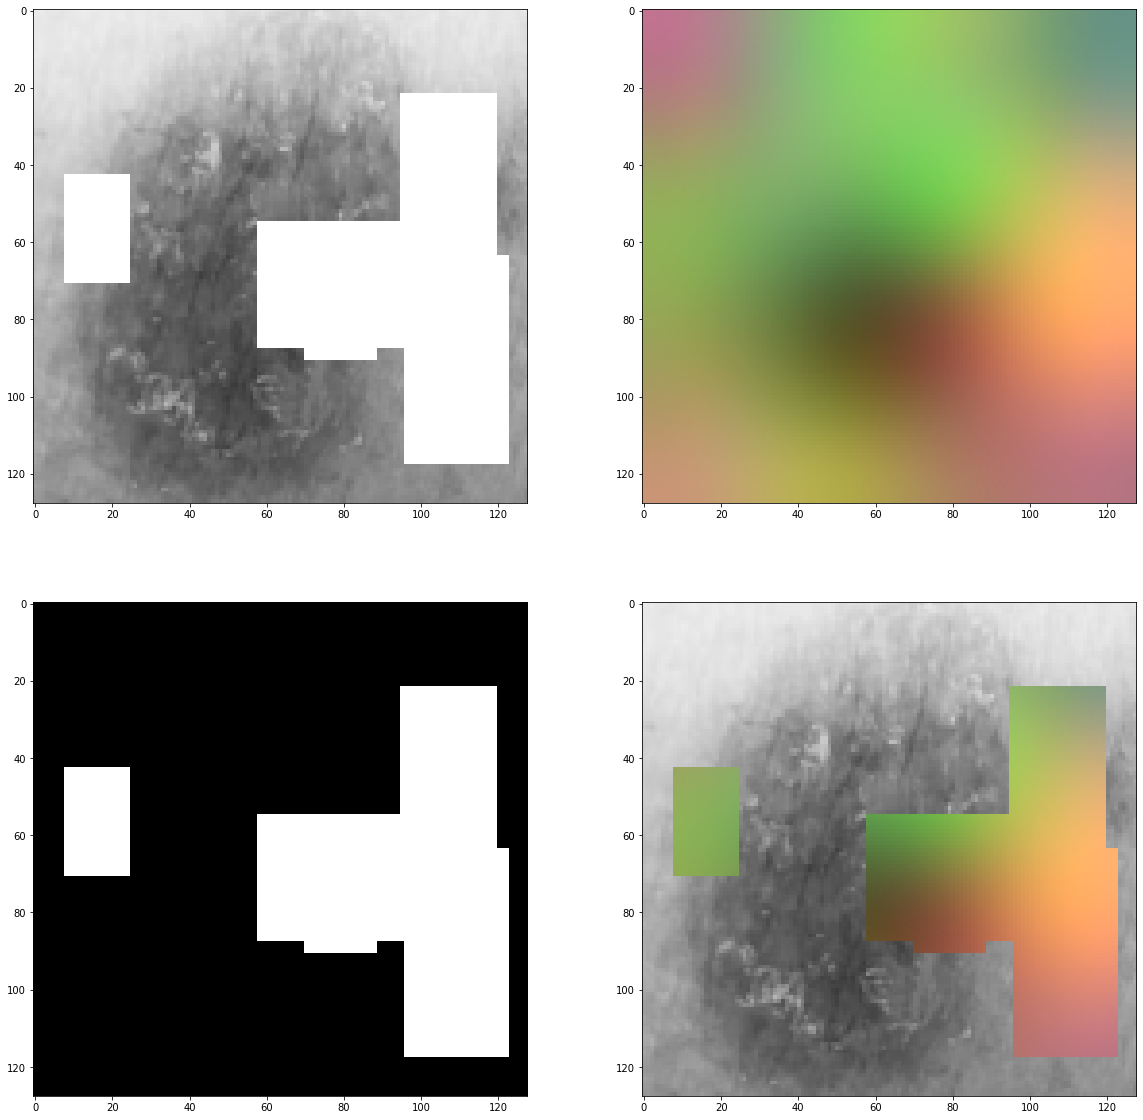

  1%|▏         | 200/16000 [02:42<3:00:55,  1.46it/s]

gen_loss: 90.1454 disc_loss: 4.8872


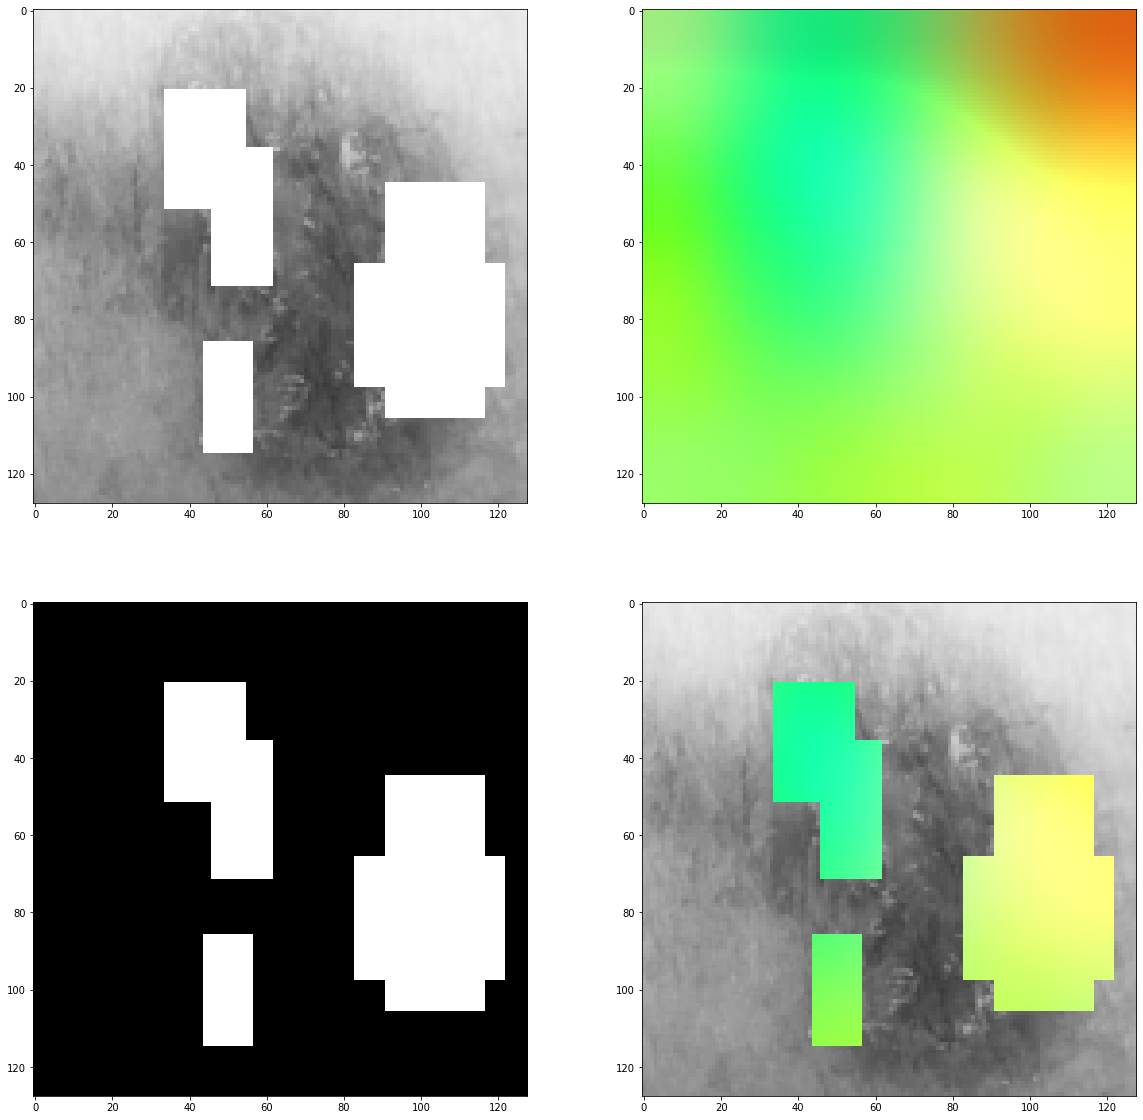

  2%|▏         | 300/16000 [04:00<2:52:48,  1.51it/s]

gen_loss: 16.4439 disc_loss: 2.1856


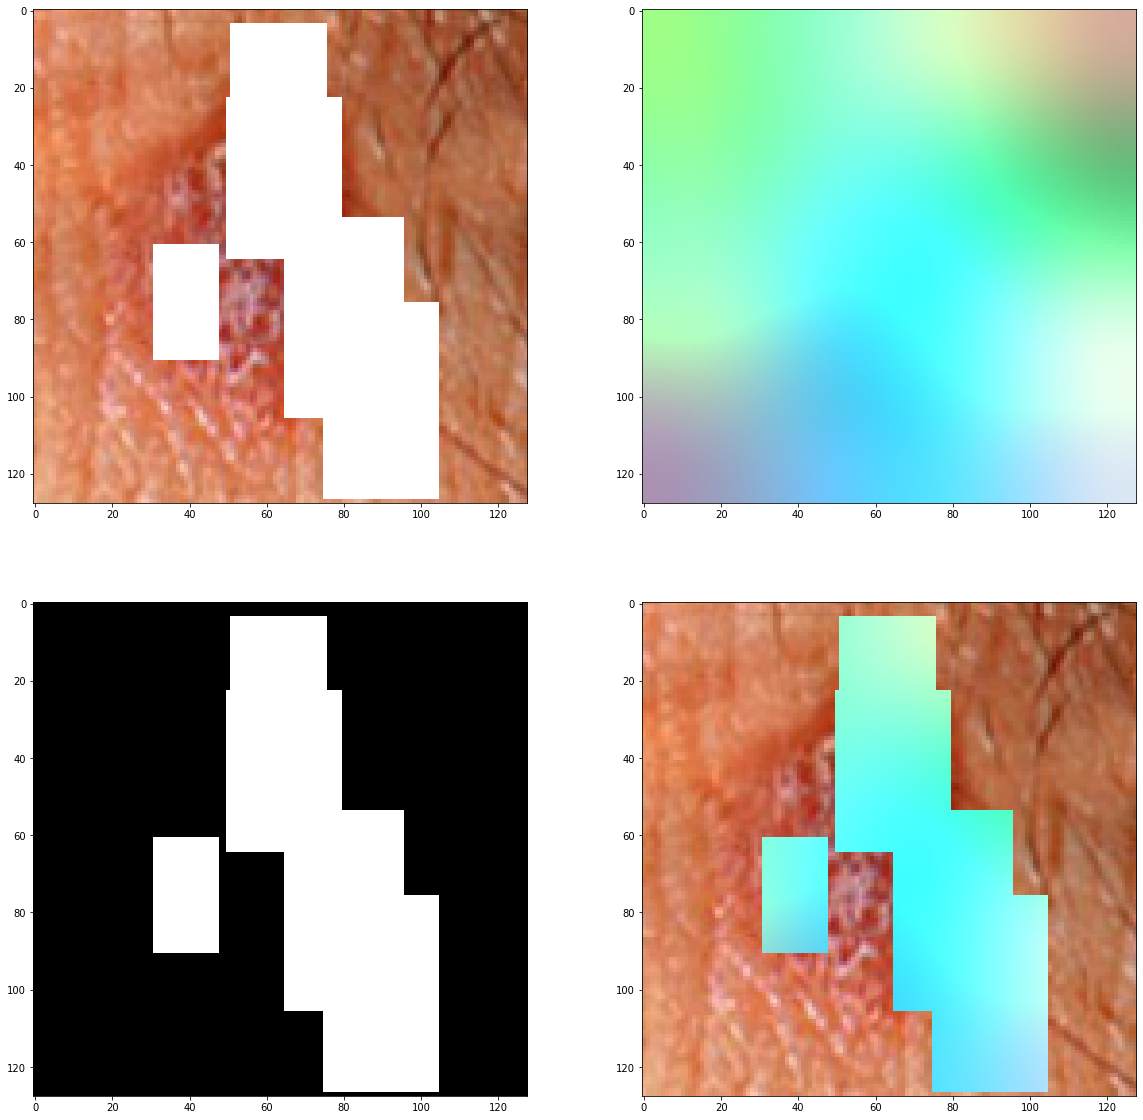

  2%|▎         | 400/16000 [05:19<3:04:48,  1.41it/s]

gen_loss: 4.5649 disc_loss: 2.1855


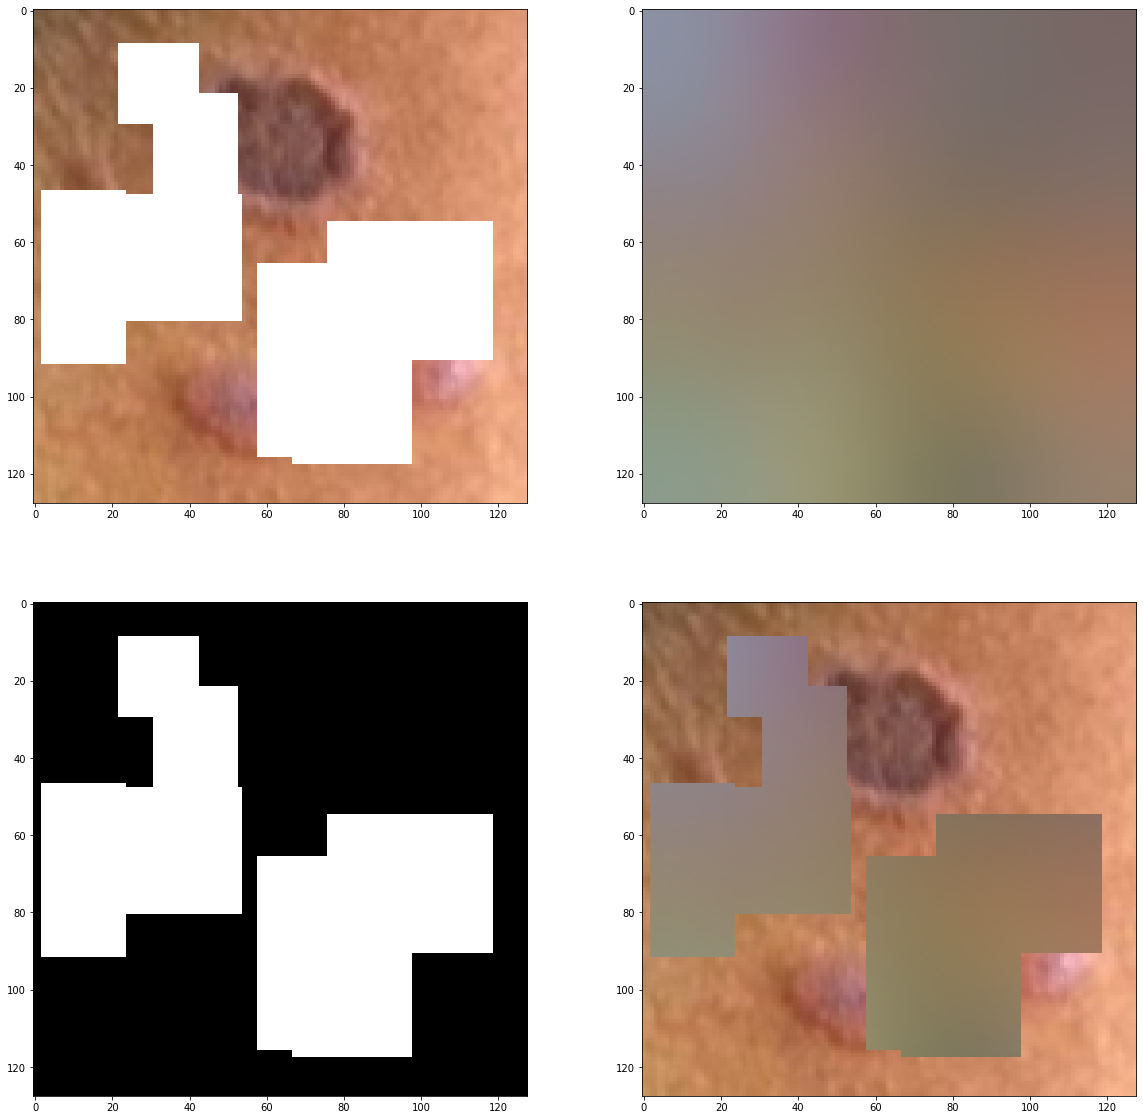

  3%|▎         | 500/16000 [06:38<2:56:03,  1.47it/s]

gen_loss: 5.7854 disc_loss: 6.7706


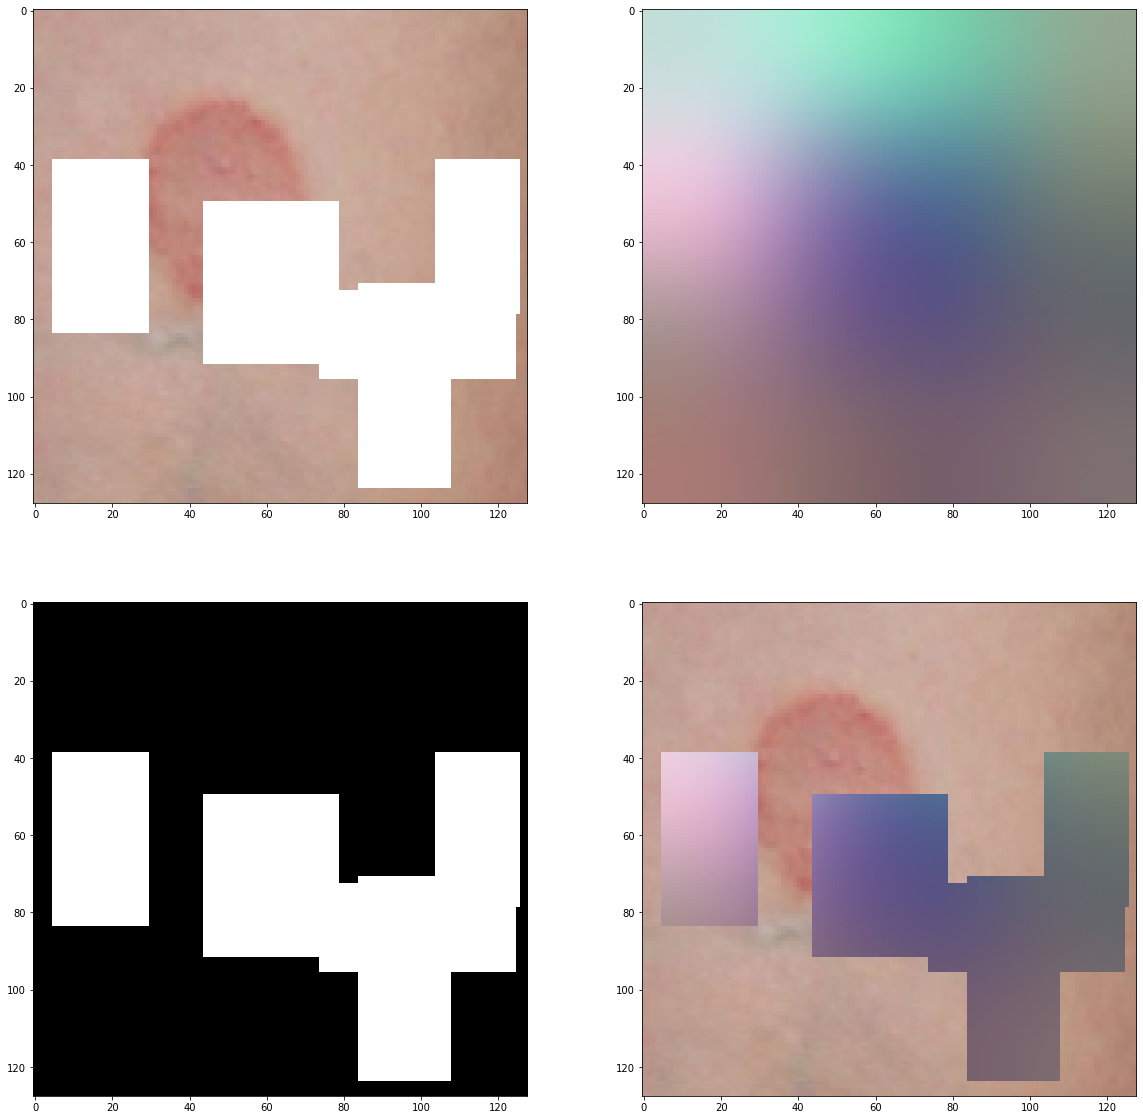

  4%|▍         | 600/16000 [07:56<3:03:52,  1.40it/s]

gen_loss: 19.7183 disc_loss: 4.1274


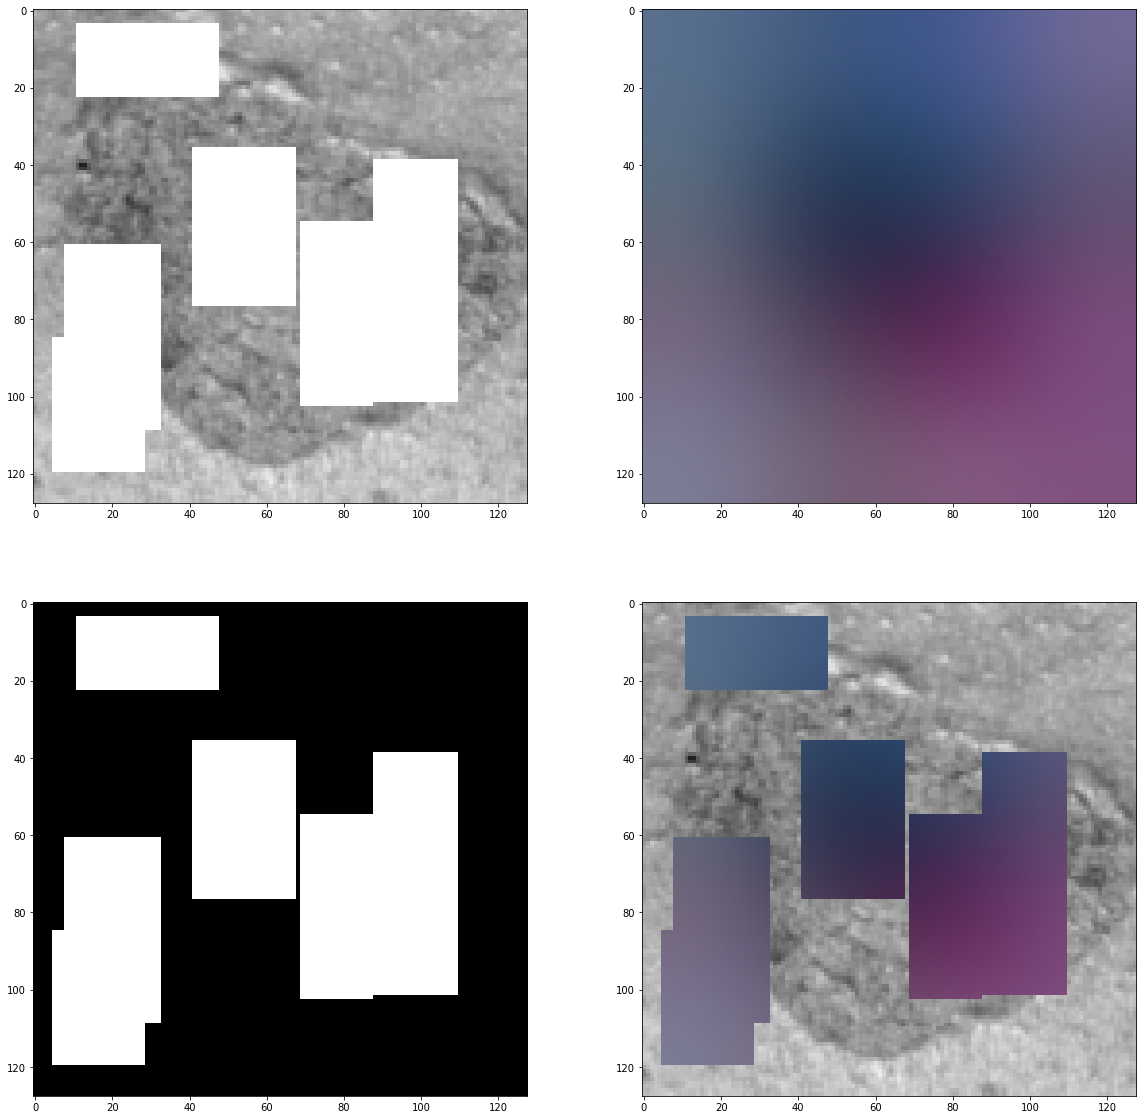

  4%|▍         | 700/16000 [09:14<2:53:00,  1.47it/s]

gen_loss: 3.8645 disc_loss: 2.0796


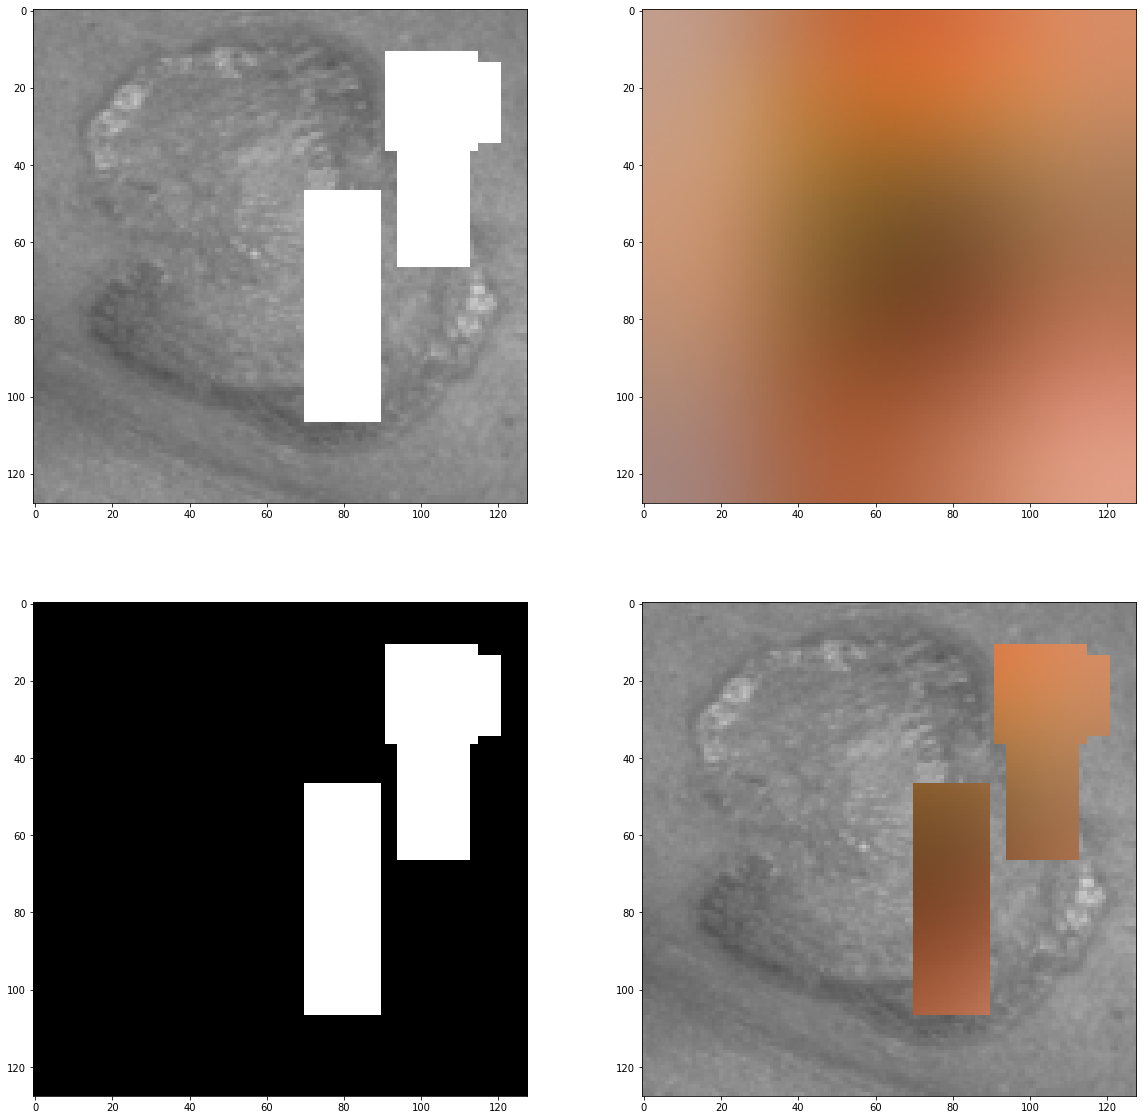

  5%|▌         | 800/16000 [10:33<2:50:12,  1.49it/s]

gen_loss: 1.9459 disc_loss: 1.8566


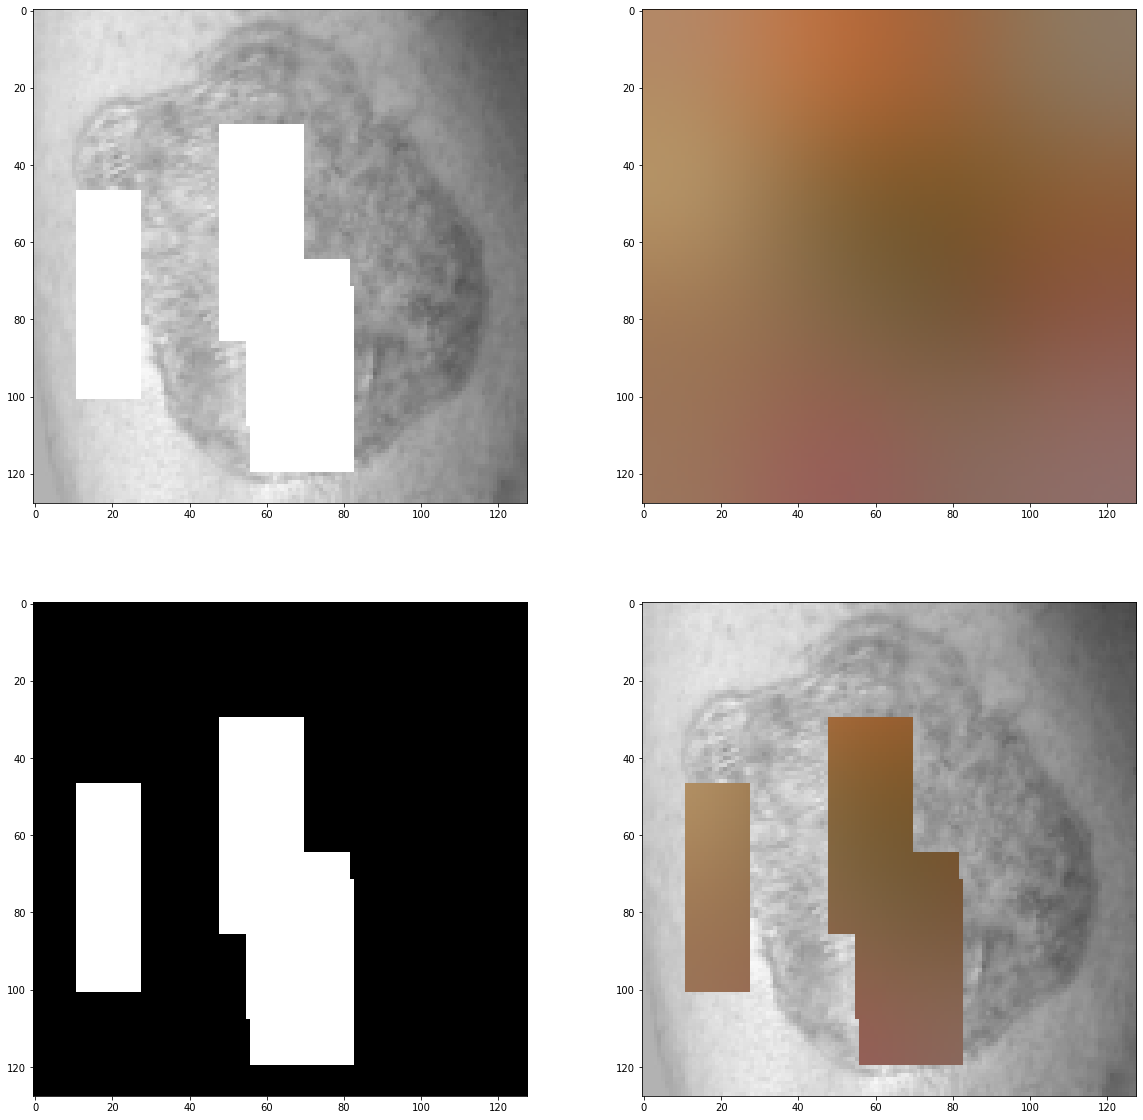

  6%|▌         | 900/16000 [11:51<2:48:01,  1.50it/s]

gen_loss: 1.973 disc_loss: 1.5893


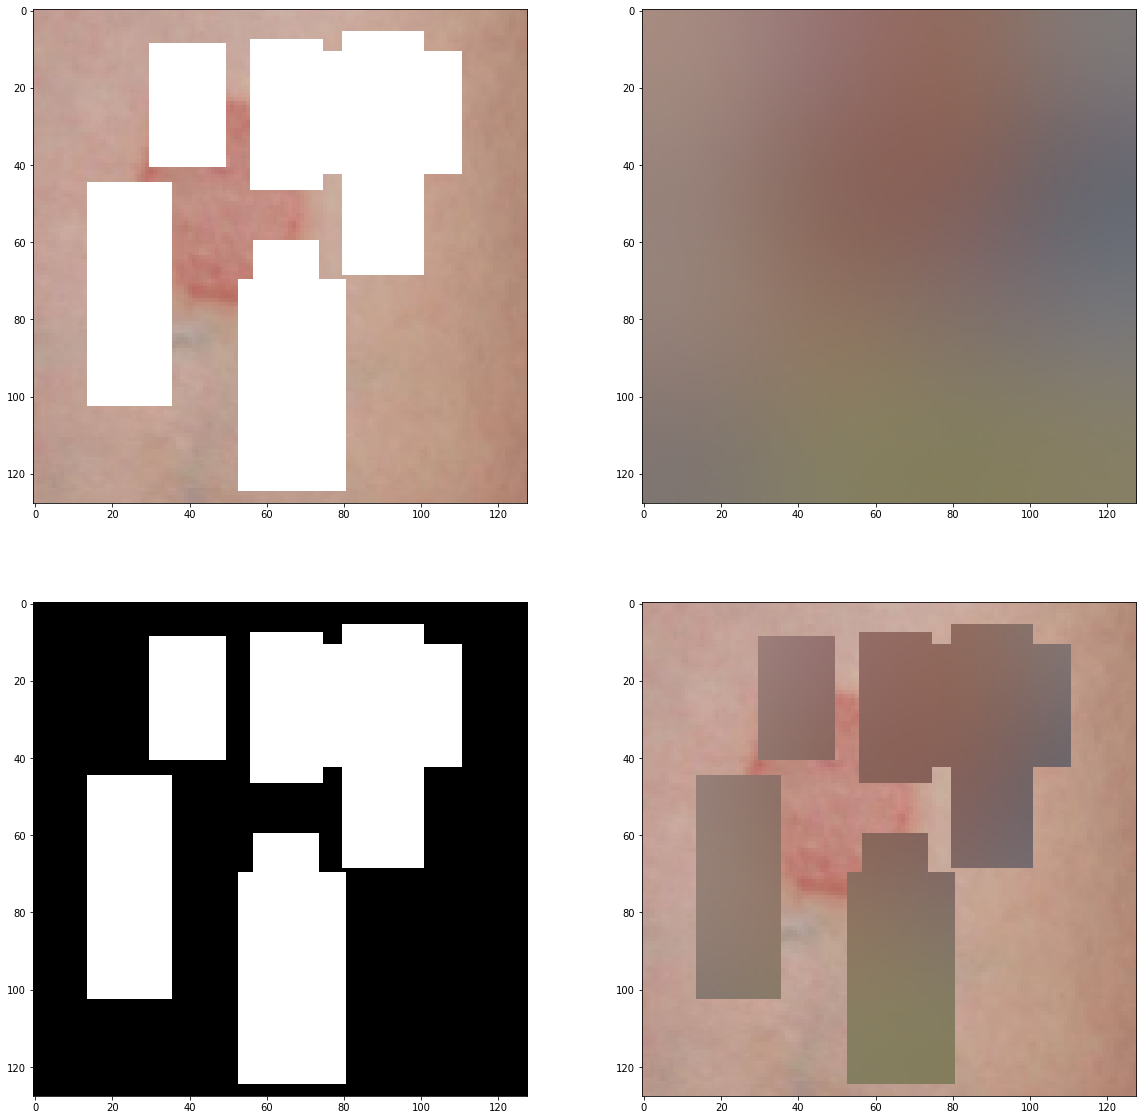

  6%|▋         | 1000/16000 [13:11<2:44:50,  1.52it/s]

gen_loss: 1.217 disc_loss: 1.5059


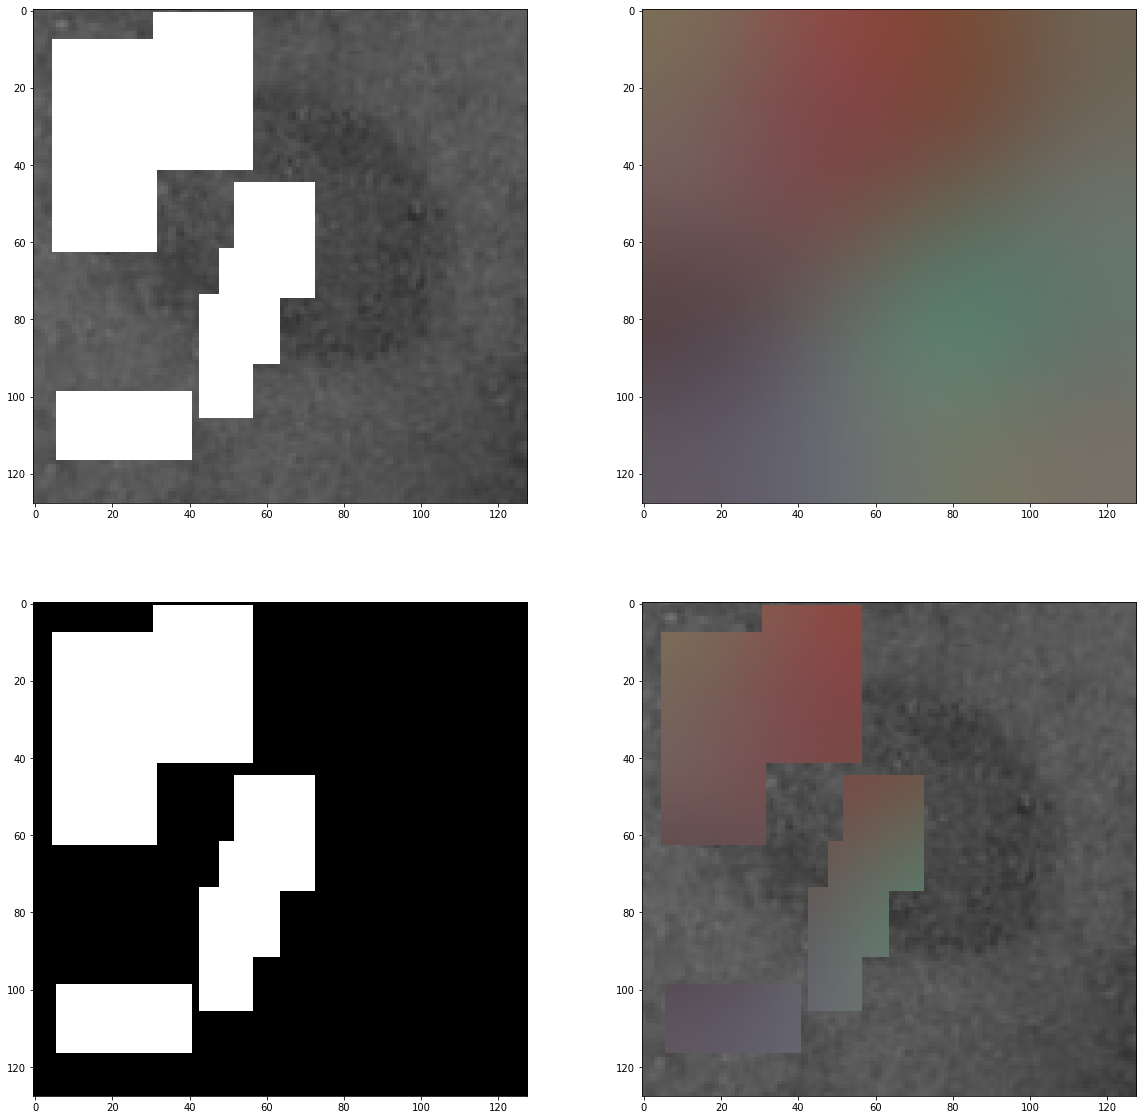

  7%|▋         | 1100/16000 [14:30<2:47:57,  1.48it/s]

gen_loss: 1.1747 disc_loss: 1.4398


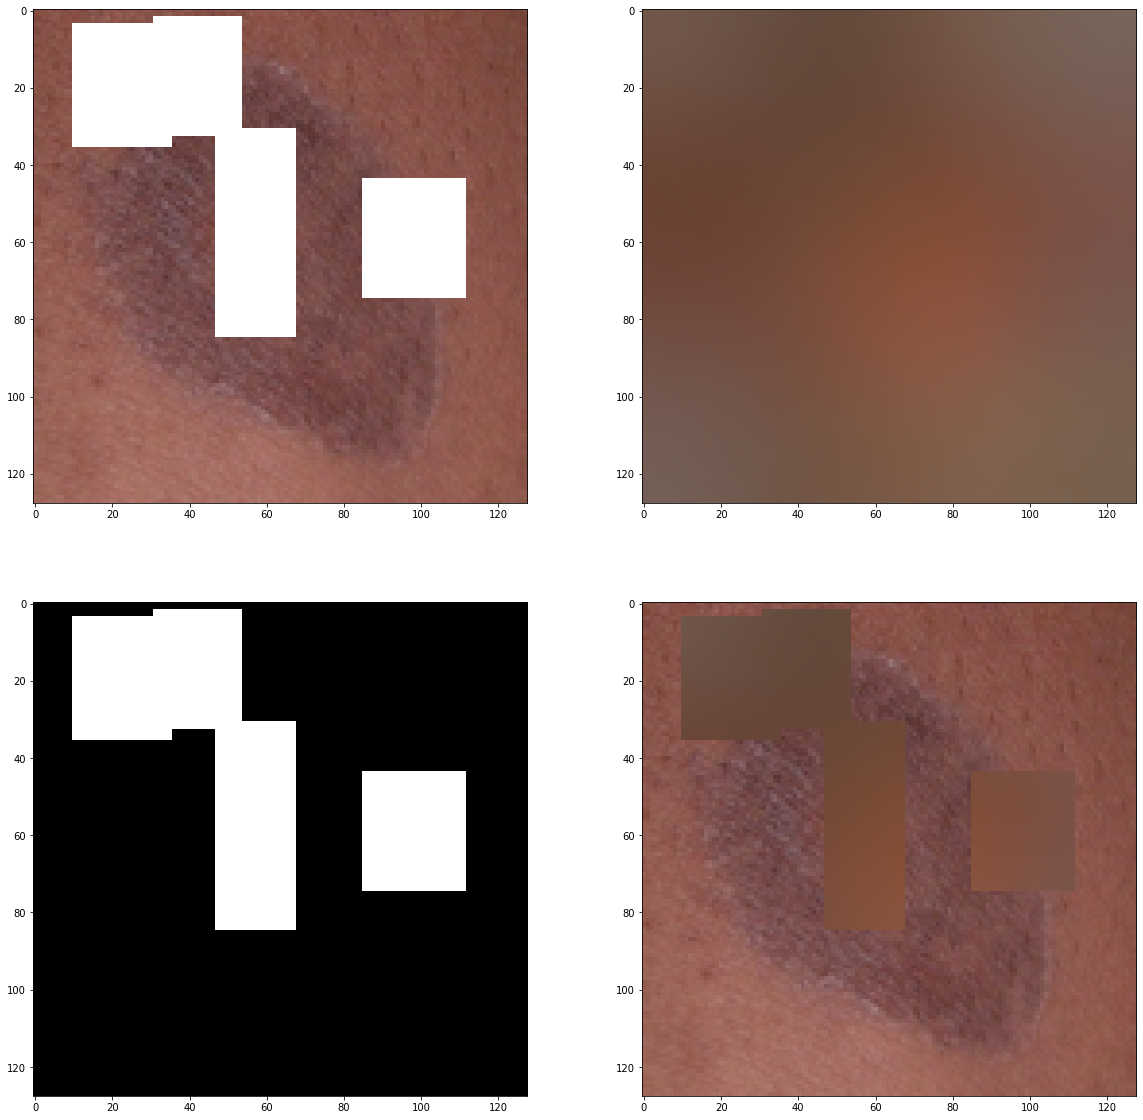

  8%|▊         | 1200/16000 [15:49<2:49:36,  1.45it/s]

gen_loss: 3.822 disc_loss: 1.5848


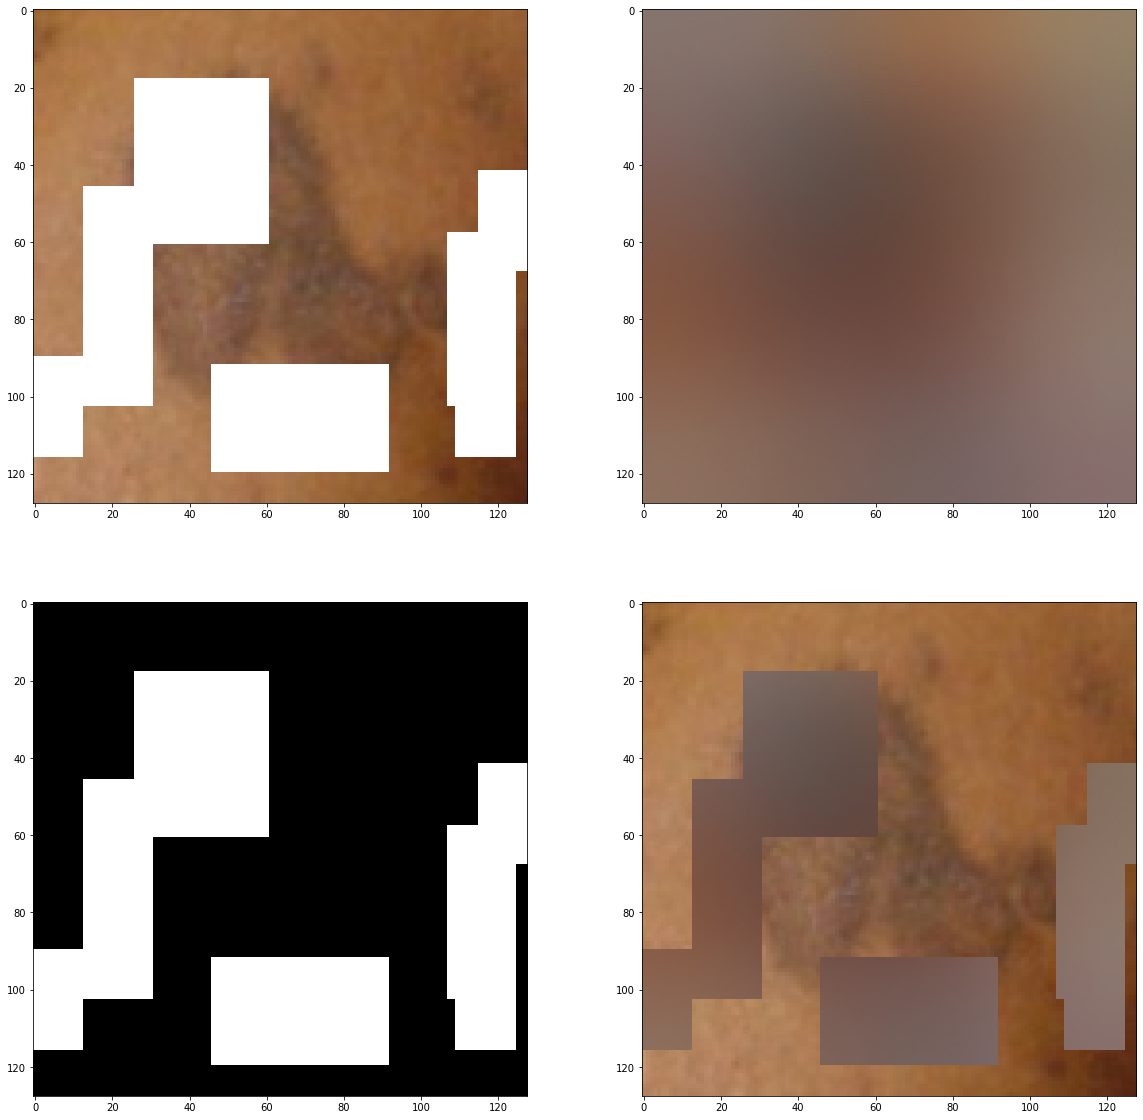

  8%|▊         | 1300/16000 [17:07<2:46:33,  1.47it/s]

gen_loss: 1.5713 disc_loss: 1.721


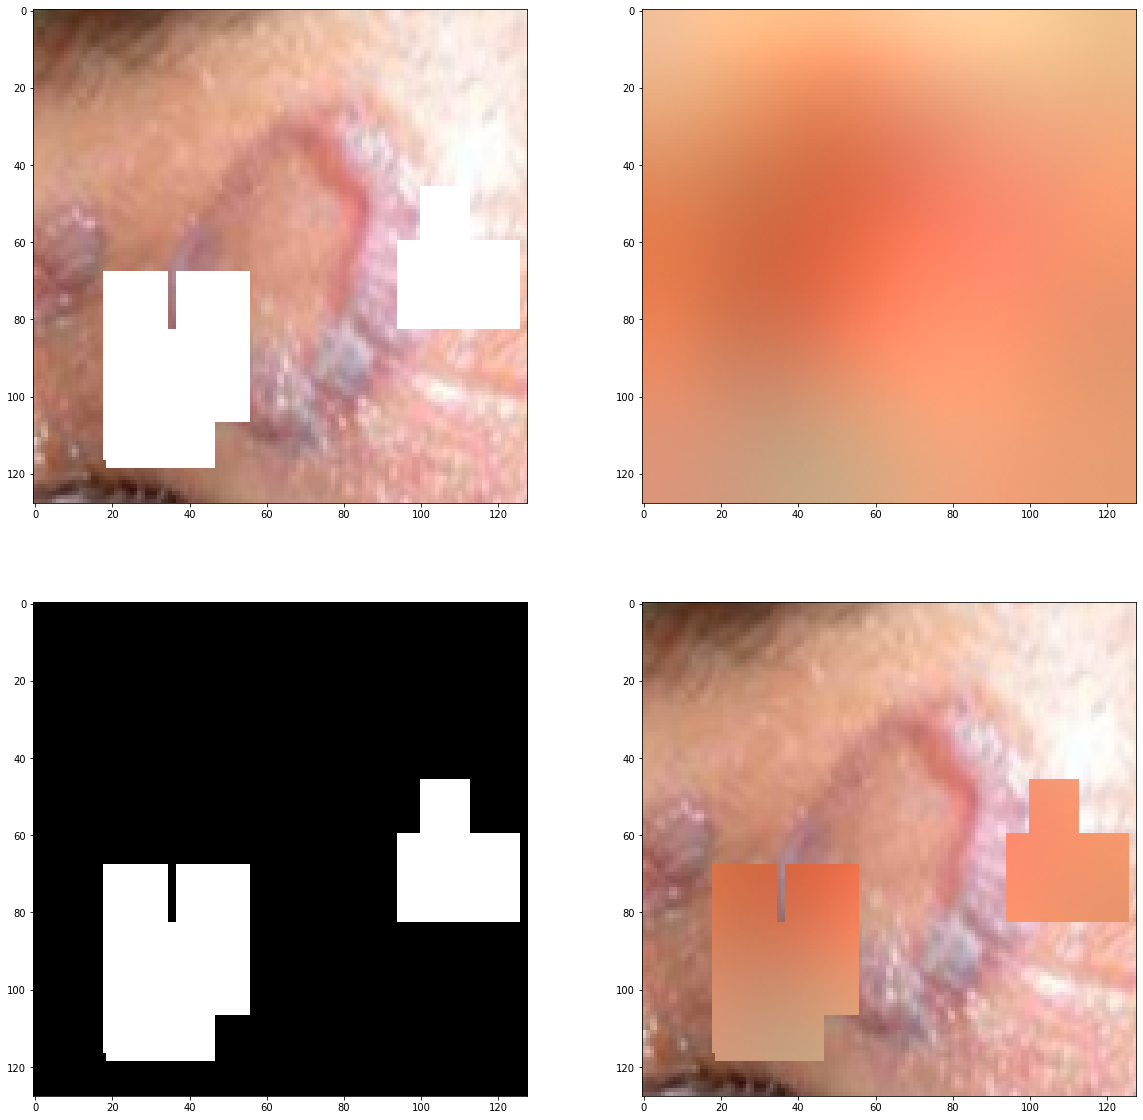

  9%|▊         | 1388/16000 [18:16<2:43:18,  1.49it/s]

In [ ]:

def cast_list(el):
    return el if isinstance(el, list) else [el]

def timestamped_filename(prefix = 'generated-'):
    now = datetime.now()
    timestamp = now.strftime("%m-%d-%Y_%H-%M-%S")
    return f'{prefix}{timestamp}'

def set_seed(seed):
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

def run_training(rank, world_size, model_args, data, load_from, new, num_train_steps, name, seed):
    is_main = rank == 0

    model_args.update(
        rank = rank,
        world_size = world_size
    )

    model = Trainer(**model_args)

    if not new:
        model.load(load_from)
    else:
        model.clear()

    model.set_data_src(data)

    for _ in tqdm(range(num_train_steps - model.steps), initial = model.steps, total = num_train_steps):
        model.train()

    model.save(model.checkpoint_num)


def train_from_folder(
    data = '/kaggle/input/annularlichenp',
    results_dir = './results',
    models_dir = './models',
    name = 'default',
    new =  True,
    load_from = -1,
    image_size = 128,
    network_capacity = 16,
    fmap_max = 512, 
    transparent = False,
    batch_size = 14,
    num_train_steps = 16000,
    learning_rate = 2e-4,
    lr_mlp = 0.1,
    ttur_mult = 1.5,
    num_workers =  None,
    save_every = 1000,
    evaluate_every = 1000,
    generate = False,
    num_generate = 1,
    generate_interpolation = False,
    interpolation_num_steps = 100,
    save_frames = False,
    num_image_tiles = 8,
    trunc_psi = 0.75,
    mixed_prob = 0.9,
    no_pl_reg = False,
    fq_layers = [],
    fq_dict_size = 256,
    attn_layers = [],
    aug_types = ['translation', 'cutout'],
    generator_top_k_gamma = 0.99,
    generator_top_k_frac = 0.5,
    calculate_fid_every = None,
    calculate_fid_num_images = 12800,
    clear_fid_cache = False,
    seed = 42,
):
    model_args = dict(
        name = name,
        results_dir = results_dir,
        models_dir = models_dir,
        batch_size = batch_size,
        image_size = image_size,
        network_capacity = network_capacity,
        fmap_max = fmap_max,
        transparent = transparent,
        lr = learning_rate,
        lr_mlp = lr_mlp,
        ttur_mult = ttur_mult,
        num_workers = num_workers,
        save_every = save_every,
        evaluate_every = evaluate_every,
        num_image_tiles = num_image_tiles,
        trunc_psi = trunc_psi,
        no_pl_reg = no_pl_reg,
        fq_layers = fq_layers,
        fq_dict_size = fq_dict_size,
        attn_layers = attn_layers,
        aug_types = cast_list(aug_types),
        generator_top_k_gamma = generator_top_k_gamma,
        generator_top_k_frac = generator_top_k_frac,
        calculate_fid_every = calculate_fid_every,
        calculate_fid_num_images = calculate_fid_num_images,
        clear_fid_cache = clear_fid_cache,
        mixed_prob = mixed_prob,
    )

    if generate:
        model = Trainer(**model_args)
        model.load(load_from)
        samples_name = timestamped_filename()
        for num in tqdm(range(num_generate)):
            model.evaluate(f'{samples_name}-{num}', num_image_tiles)
        
        print(f'sample images generated at {results_dir}/{name}/{samples_name}')
        return

    if generate_interpolation:
        model = Trainer(**model_args)
        model.load(load_from)
        samples_name = timestamped_filename()
        model.generate_interpolation(samples_name, num_image_tiles, num_steps = interpolation_num_steps, save_frames = save_frames)
        print(f'interpolation generated at {results_dir}/{name}/{samples_name}')
        return


    run_training(0, 1, model_args, data, load_from, new, num_train_steps, name, seed)
        

train_from_folder()